# ***Multiple output Model***

# ***Wine Quality Prediction and Wine Type Classification***

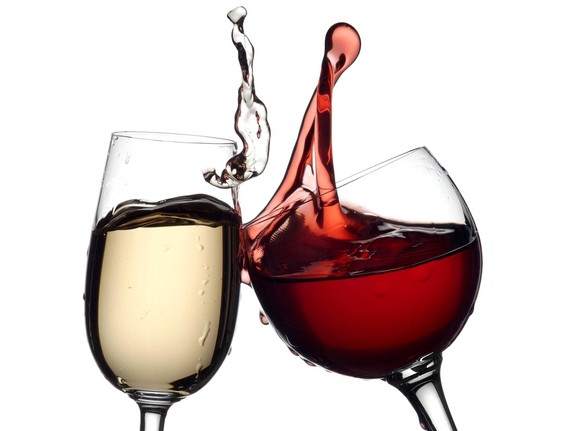

## ***importing libraries***

In [ ]:
import tensorflow as tf
import tensorflow.keras as ks
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

## ***Loading white wine and red wine dataset and concatinating them***

In [ ]:
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv'

white_df = pd.read_csv(URL, sep=';')
print(white_df.shape)
white_df['is_red'] = 0
white_df = white_df.drop_duplicates(keep='first')
print(white_df.shape)
white_df.head()

In [ ]:
URL = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'

red_df = pd.read_csv(URL, sep=';')
print(red_df.shape)
red_df['is_red'] = 1
red_df = red_df.drop_duplicates(keep='first')
print(red_df.shape)
red_df.head()

In [ ]:
df = pd.concat([red_df, white_df], ignore_index=True)
print(df.shape)
df.sample(5)

### ***quality of wine visualization***

In [ ]:
plt.style.use('seaborn')
df['quality'].hist(bins=20)

## ***as there are only a few number of samples in 3, 4, 8, 9 , let's kick it out from the dataset***

In [ ]:
df = df[(df['quality'] > 4) & (df['quality'] < 8)]
df = df.reset_index(drop=True)

In [ ]:
df['quality'].hist(bins=20)

## ***spliting the dataset into train and test set and further split it for validation***

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=1)
train, validation = train_test_split(train, test_size=0.2, random_state=1)

In [ ]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.T
train_stats

## ***Lets seperate the independent variable from the dependent***

In [ ]:
def format_output(data):
  is_red = data.pop('is_red')
  quality = data.pop('quality')
  is_red = np.array(is_red)
  quality = np.array(quality)
  return is_red, quality

train_y = format_output(train)
valid_y = format_output(validation)
test_y = format_output(test)

In [ ]:
def norm(x):
  return (x-train_stats['mean'])/train_stats['std']

train_x = norm(train)
valid_x = norm(validation)
test_x = norm(test)

## ***creating the model***

In [ ]:
def base_model(inputs):
  x = Dense(units=128, activation='relu', name='Dense_1')(inputs)
  x = Dense(units=128, activation='relu', name='Dense_2')(x)
  return x

def final_model(inputs):
  x = base_model(inputs)
  wine_quality = Dense(units='1', name='wine_quality')(x)
  wine_type = Dense(units='1', activation='sigmoid', name='wine_type')(x)
  model = Model(inputs=inputs, outputs=[wine_type, wine_quality])
  return model

inputs = Input(shape=(11, ))
model = final_model(inputs)
model.summary()

In [ ]:
ks.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer=ks.optimizers.RMSprop(lr=0.0001), loss={
    'wine_quality': 'mean_squared_error', 
    'wine_type': 'binary_crossentropy'
}, metrics={'wine_quality': ['RootMeanSquaredError'], 
            'wine_type': ['accuracy']
            })

In [ ]:
history = model.fit(x=train_x, y=train_y, epochs=700, validation_data=(valid_x, valid_y), verbose=0)

In [ ]:
for i in history.history:
  print(i)

### ***Let's see some visuals on how the model performs***

In [ ]:
loss, wine_type_loss, wine_quality_loss, wine_type_accuracy, wine_quality_root_mean_squared_error = model.evaluate(test_x, test_y)

print(f'Loss = {loss}\nwine_type_loss = {wine_type_loss}\nwine_quality_loss = {wine_quality_loss}')
print(f'wine_type_accuracy = {wine_type_accuracy}\nwine_quality_rmse = {wine_quality_root_mean_squared_error}')

In [ ]:
def plot_metrics(metric_name, title, ylim=5):
  plt.style.use('ggplot')
  plt.figure(figsize=(7, 5))
  plt.plot(history.history[metric_name], color='blue', label=metric_name)
  plt.plot(history.history['val_'+metric_name], color='green', label='val_'+metric_name)
  plt.xlim(0, 3)
  plt.xlabel('epochs')
  plt.title(title)
  plt.legend()
  plt.show()

In [ ]:
def conf_matrix(y_true, y_preds):
  cnf = confusion_matrix(y_true, y_preds)
  sns.heatmap(cnf, annot=True, fmt='g', cmap='Blues')
  plt.title('confusion_matrix for wine_type')

In [ ]:
def plot_diff(y_true, y_preds, title=''):
  plt.style.use('fivethirtyeight')
  plt.figure(figsize=(7, 6))
  plt.scatter(y_true, y_preds)
  plt.title(title)
  plt.xlabel('True Value')
  plt.ylabel('predicted value')
  plt.axis('equal')
  plt.axis('square')
  plt.plot([-100, 100], [-100, 100])
  plt.show()

In [ ]:
y_preds = model.predict(test_x)

In [ ]:
plot_metrics('wine_quality_root_mean_squared_error', 'Root_mean_squared_error')

In [ ]:
plot_metrics('wine_type_loss', 'wine type loss', ylim=7)

In [ ]:
type_preds = np.round(y_preds[0])

conf_matrix(test_y[0], type_preds)

In [ ]:
plot_diff(test_y[1], y_preds[1], title='wine quality prediction difference plot')